In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("eval_practice.csv")

In [3]:
from sklearn.model_selection import train_test_split
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
categorical_columns = list(df.dtypes[df.dtypes == "str"].index)
for c in categorical_columns:
    df[c] = df[c].str.strip().str.lower().str.replace(" ", "_")
df.totalcharges = pd.to_numeric(df.totalcharges, errors="coerce") # tries to convert to numeric and replaces
df.totalcharges = df.totalcharges.fillna(0)
df.churn = (df.churn == "yes").astype(int)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values
try:
    del df_train["churn"]
except KeyError:
    pass
try:
    del df_val["churn"]
except KeyError:
    pass
try:
    del df_test["churn"]
except KeyError:
    pass
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [4]:
numerical = ["tenure", "monthlycharges", "totalcharges"]
categorical = [l for l in df_full_train.columns if l not in numerical + ["churn", "customerid"]]

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dict)
model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)

D:\PyProjects\machine-learning-zoomcamp\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [6]:
val_dict = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.fit_transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

In [7]:
# 80% of decisions were correct meaning that we correctly predicted 80% of customers churning/not churning
# 1409 - customers
# 1132 customers for correctly predicted that they are either churn or not churn
# 80% accuracy != we correctly predicted churn rate in 80% of cases

In [8]:
# Our baseline was if prediction is >=0.5 than the person is going to churn
# But what if change the baseline to either 0.3 or 0.6

In [9]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [10]:
scores = []
for i, t in enumerate(thresholds):
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    scores.append(score)
    print(score.round(3), t.round(2))
# The maximum accuracy is 80% received at 0.5 threshold

0.274 0.0
0.51 0.05
0.592 0.1
0.667 0.15
0.71 0.2
0.739 0.25
0.76 0.3
0.772 0.35
0.785 0.4
0.794 0.45
0.803 0.5
0.801 0.55
0.796 0.6
0.786 0.65
0.766 0.7
0.744 0.75
0.734 0.8
0.726 0.85
0.726 0.9
0.726 0.95
0.726 1.0


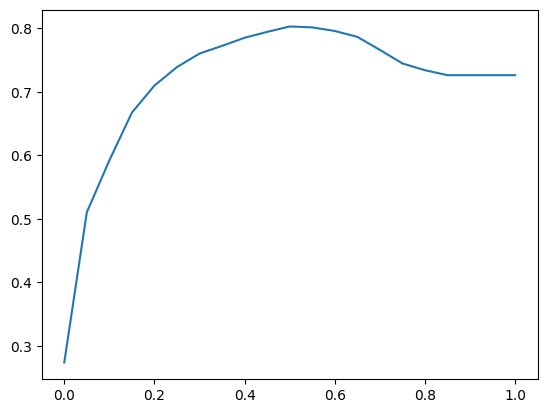

In [11]:
plt.plot(thresholds, scores)

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [13]:
accuracy_score(y_val, y_pred >= 0.5)

0.8026969481902059

In [14]:
scores = []
for i, t in enumerate(thresholds):
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(score)
    print(round(score, 3), round(t, 2))
# The maximum accuracy is 80% received at 0.5 threshold

0.274 0.0
0.51 0.05
0.592 0.1
0.667 0.15
0.71 0.2
0.739 0.25
0.76 0.3
0.772 0.35
0.785 0.4
0.794 0.45
0.803 0.5
0.801 0.55
0.796 0.6
0.786 0.65
0.766 0.7
0.744 0.75
0.734 0.8
0.726 0.85
0.726 0.9
0.726 0.95
0.726 1.0


In [15]:
# Interesting stuff - scores at 0.0 and 1.0 are 0.274 and 0.726 respectively
# That means that "dummy" models that say that customer is always churning or never churning are 27% and 73% accurate respectively
# Model accuracy != Model quality
from collections import Counter
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [16]:
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [17]:
y_val.mean()

np.float64(0.2739531582682754)

In [18]:
# Validation data tells us that in that dataset 27% of customers are churning same as result above

In [19]:
# This is called 'Class imbalance'
# We have 3 : 1 ratio of non-churning to churning customers

In [20]:
# Confusion table
# For each customer we predict churn or no churn
# Then
# If we predicted churn and
# He churned - True Positive y_pred >= t & y_val == 1
# He didn't churn - False Positive y_pred >= t & y_val == 0
# If we predicted no churn and
# He churned - False Negative y_pred < t & y_val == 1
# He didn't churn - True Negative y_pred < t & y_val == 0

In [21]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [22]:
actual_negative

array([ True,  True,  True, ...,  True, False, False], shape=(1409,))

In [23]:
actual_positive

array([False, False, False, ..., False,  True,  True], shape=(1409,))

In [24]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [25]:
predict_positive[22]

np.False_

In [26]:
actual_positive[22]

np.True_

In [27]:
# The 22nd person in validation dataset churned, but we predicted that he did not, thus making him false negative

In [28]:
predict_positive & actual_positive

array([False, False, False, ..., False,  True,  True], shape=(1409,))

In [29]:
tp = (predict_positive & actual_positive).sum() # True positive
tn = (predict_negative & actual_negative).sum() # True negative

In [30]:
tp, tn # 210 true positive and 921 true negative

(np.int64(210), np.int64(921))

In [31]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [32]:
fp, fn # 102 false positive and 176 false negative

(np.int64(102), np.int64(176))

In [33]:
# Confusion matrix is
# | TN | FP |
# | FN | TP |

In [34]:
# Our confusion matrix
# | 922 | 102 |
# | 176 | 210 |

In [35]:
confusion_mtx = np.array([
    [tn, fp],
    [fn, tp]
])

In [36]:
confusion_mtx

array([[921, 102],
       [176, 210]])

In [37]:
(confusion_mtx / confusion_mtx.sum()).round(2)
# | 65 % | 8 %  |
# | 12 % | 15 % |

array([[0.65, 0.07],
       [0.12, 0.15]])

In [38]:
# Accuracy
(tp + tn) / (tp + tn + fp + fn)

np.float64(0.8026969481902059)

In [39]:
# Precision is metric of fraction of positive predictions that are correct
prec = tp / (tp + fp)

In [40]:
prec

np.float64(0.6730769230769231)

In [41]:
# Precision is 67% - 210/312

In [42]:
# Recall is metric of fraction of correctly identified positive examples
rcl = tp / (tp + fn)
rcl

np.float64(0.5440414507772021)

In [43]:
# Recall is 54% - 210/386

In [44]:
# Accuracy - 80% <- misleading
# Precision - 67%
# Recall - 54%

In [45]:
# Receiver operating characteristics - ROC

In [46]:
# False positive rate (FPR) - all the negative examples
fpr = fp / (fp + tn)
fpr

np.float64(0.09970674486803519)

In [47]:
# FPR is 10%

In [48]:
# True positive rate (TPR) - all the positive examples (also known as recall or sensitivity)
tpr = tp / (fn + tp)
tpr

np.float64(0.5440414507772021)

In [49]:
# TPR is 54%

In [50]:
# Our goals are:
# 1. FPR down
# 2. TPR up

In [51]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((t, tp, tn, fp, fn))

In [52]:
scores

[(np.float64(0.0), np.int64(386), np.int64(0), np.int64(1023), np.int64(0)),
 (np.float64(0.01), np.int64(385), np.int64(111), np.int64(912), np.int64(1)),
 (np.float64(0.02), np.int64(384), np.int64(194), np.int64(829), np.int64(2)),
 (np.float64(0.03), np.int64(383), np.int64(257), np.int64(766), np.int64(3)),
 (np.float64(0.04), np.int64(381), np.int64(308), np.int64(715), np.int64(5)),
 (np.float64(0.05), np.int64(379), np.int64(340), np.int64(683), np.int64(7)),
 (np.float64(0.06), np.int64(377), np.int64(364), np.int64(659), np.int64(9)),
 (np.float64(0.07), np.int64(372), np.int64(382), np.int64(641), np.int64(14)),
 (np.float64(0.08), np.int64(371), np.int64(411), np.int64(612), np.int64(15)),
 (np.float64(0.09), np.int64(369), np.int64(443), np.int64(580), np.int64(17)),
 (np.float64(0.1), np.int64(366), np.int64(468), np.int64(555), np.int64(20)),
 (np.float64(0.11), np.int64(365), np.int64(495), np.int64(528), np.int64(21)),
 (np.float64(0.12), np.int64(365), np.int64(514), 

In [53]:
# Our goal is to find the best threshold
# With this we need to compute the confusion matrix for every threshold

In [54]:
columns = ["threshold", "tp", "tn", "fp", "fn"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10] # Every 10th record

,threshold,tp,tn,fp,fn
0,0.0,386,0,1023,0
10,0.1,366,468,555,20
20,0.2,333,667,356,53
30,0.3,284,787,236,102
40,0.4,249,857,166,137
50,0.5,210,921,102,176
60,0.6,151,970,53,235
70,0.7,76,1003,20,310
80,0.8,13,1021,2,373
90,0.9,0,1023,0,386


In [55]:
df_scores["tpr"] = df_scores.tp / (df_scores.fn + df_scores.tp)
df_scores["fpr"] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [56]:
df_scores[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,366,468,555,20,0.948187,0.542522
20,0.2,333,667,356,53,0.862694,0.347996
30,0.3,284,787,236,102,0.735751,0.230694
40,0.4,249,857,166,137,0.645078,0.162268
50,0.5,210,921,102,176,0.544041,0.099707
60,0.6,151,970,53,235,0.391192,0.051808
70,0.7,76,1003,20,310,0.196891,0.019550
80,0.8,13,1021,2,373,0.033679,0.001955
90,0.9,0,1023,0,386,0.000000,0.000000


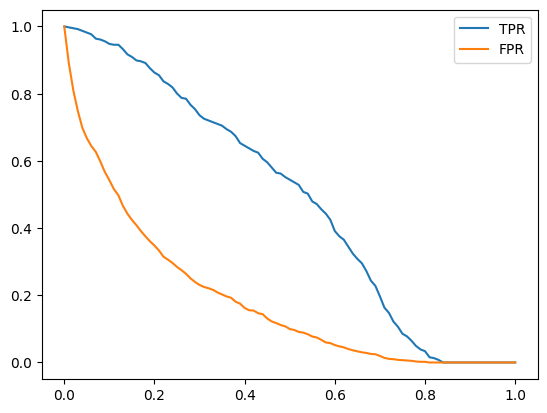

In [57]:
plt.plot(df_scores.threshold, df_scores.tpr, label="TPR")
plt.plot(df_scores.threshold, df_scores.fpr, label="FPR")
plt.legend()

In [58]:
# We can compare out model to random model - a model that randomly chooses either positive or negative

In [59]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089], shape=(1409,))

In [60]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [61]:
# The accuracy of random model is 50%

In [62]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, tn, fp, fn))
    columns = ["threshold", "tp", "tn", "fp", "fn"]
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores["tpr"] = df_scores.tp / (df_scores.fn + df_scores.tp)
    df_scores["fpr"] = df_scores.fp / (df_scores.fp + df_scores.tn)
    return df_scores

In [63]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [64]:
df_rand[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,347,100,923,39,0.898964,0.902248
20,0.2,307,201,822,79,0.795337,0.803519
30,0.3,276,299,724,110,0.715026,0.707722
40,0.4,237,399,624,149,0.613990,0.609971
50,0.5,202,505,518,184,0.523316,0.506354
60,0.6,161,614,409,225,0.417098,0.399804
70,0.7,121,721,302,265,0.313472,0.295210
80,0.8,78,817,206,308,0.202073,0.201369
90,0.9,40,922,101,346,0.103627,0.098729


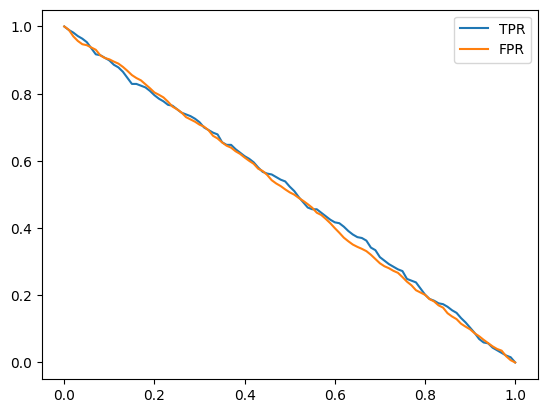

In [65]:
plt.plot(df_rand.threshold, df_rand.tpr, label="TPR")
plt.plot(df_rand.threshold, df_rand.fpr, label="FPR")
plt.legend()

In [66]:
# Random model is a straight line

In [67]:
# We can also benchmark our model against an ideal model

In [68]:
# Ideal model is such model that for the first values of probabilities of positive example are below the threshold and after the threshold they are above it
# Threshold of 0.6
# Ideal model
#  __________________________________
# |----negative-----|----positive----|
# |0.01|0.02|...|0.4|0.6|0.7|...|0.99|

In [69]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [70]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos]) # Repeats zeroes for num_neg times and ones for num_pos times
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [71]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [72]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [73]:
# Total num of examples - 1409
# 72,6% of them are negative and rest are positive
# So the ideal model correctly guesses that any observation above threshold of 0.726 is positive and others are negative

In [74]:
((y_ideal_pred >= (1 - y_val.mean())) == y_ideal).mean()

np.float64(1.0)

In [75]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

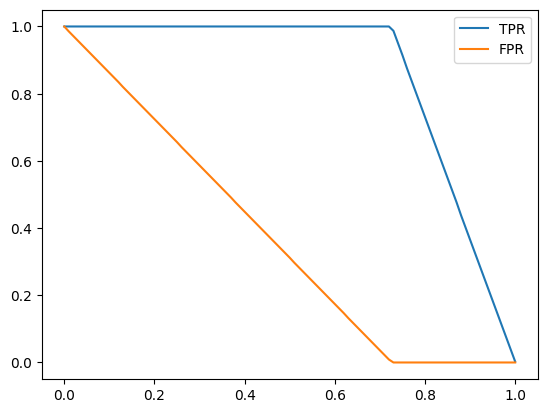

In [76]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label="TPR")
plt.plot(df_ideal.threshold, df_ideal.fpr, label="FPR")
plt.legend()

In [77]:
# This is the ideal model graph

In [78]:
# Combine all of them

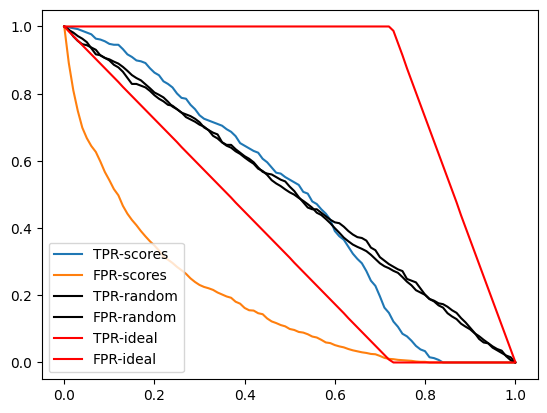

In [79]:
plt.plot(df_scores.threshold, df_scores.tpr, label="TPR-scores")
plt.plot(df_scores.threshold, df_scores.fpr, label="FPR-scores")
plt.plot(df_rand.threshold, df_rand.tpr, label="TPR-random", color="black")
plt.plot(df_rand.threshold, df_rand.fpr, label="FPR-random", color="black")
plt.plot(df_ideal.threshold, df_ideal.tpr, label="TPR-ideal", color="red")
plt.plot(df_ideal.threshold, df_ideal.fpr, label="FPR-ideal", color="red")
plt.legend()

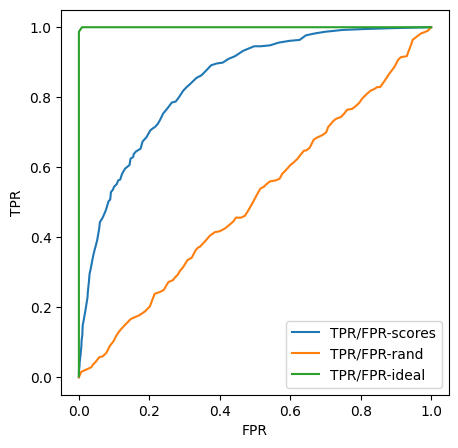

In [80]:
plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr, df_scores.tpr, label="TPR/FPR-scores")
plt.plot(df_rand.fpr, df_rand.tpr, label="TPR/FPR-rand")
plt.plot(df_ideal.fpr, df_ideal.tpr, label="TPR/FPR-ideal")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()


In [81]:
# As stated before out goal is maximizing TPR and minimizing FPR
# Thus at specific threshold TPR (very large) / FPR (very tiny) -> 1.0 (e.g. 99.9% TPR and 0.01% FPR)

In [82]:
from sklearn.metrics import roc_curve

In [83]:
# sklearn has a roc curve function
roc_curve(y_val, y_pred)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.77517107e-04,
        9.77517107e-04, 1.95503421e-03, 1.95503421e-03, 2.93255132e-03,
        2.93255132e-03, 3.91006843e-03, 3.91006843e-03, 4.88758553e-03,
        4.88758553e-03, 5.86510264e-03, 5.86510264e-03, 6.84261975e-03,
        6.84261975e-03, 7.82013685e-03, 7.82013685e-03, 9.77517107e-03,
        9.77517107e-03, 1.07526882e-02, 1.07526882e-02, 1.27077224e-02,
        1.27077224e-02, 1.36852395e-02, 1.36852395e-02, 1.46627566e-02,
        1.46627566e-02, 1.66177908e-02, 1.66177908e-02, 1.85728250e-02,
        1.85728250e-02, 1.95503421e-02, 1.95503421e-02, 2.05278592e-02,
        2.05278592e-02, 2.15053763e-02, 2.15053763e-02, 2.34604106e-02,
        2.34604106e-02, 2.44379277e-02, 2.44379277e-02, 2.54154448e-02,
        2.54154448e-02, 2.63929619e-02, 2.63929619e-02, 2.83479961e-02,
        2.83479961e-02, 2.93255132e-02, 2.93255132e-02, 3.03030303e-02,
        3.03030303e-02, 3.12805474e-02, 3.12805474e-02, 3.225806

In [84]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

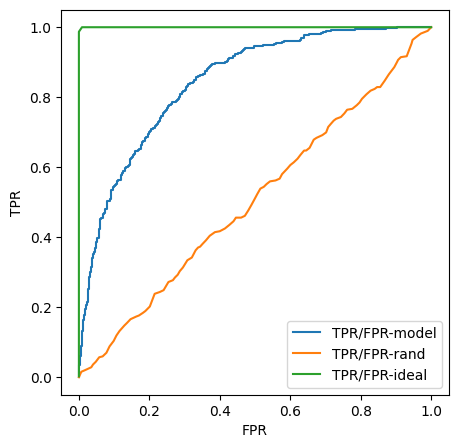

In [85]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label="TPR/FPR-model")
plt.plot(df_rand.fpr, df_rand.tpr, label="TPR/FPR-rand")
plt.plot(df_ideal.fpr, df_ideal.tpr, label="TPR/FPR-ideal")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()


In [86]:
# Our models curve must be as close as possible to ideal model and as far as possible from random model

In [89]:
# AUC - Area Under the ROC Curve
# To measure our model precision we calculate the AUC and check how close it to area of ideal model
# AUC of random model - 0.5
# AUC of ideal model - 1.0
# AUC of model must be -> 1.0

In [90]:
from sklearn.metrics import auc

In [91]:
auc(fpr, tpr) # AUC of model is 0.84

0.8438150517374987

In [92]:
auc(df_rand.fpr, df_rand.tpr) # AUC of random model is 0.50

0.5060233793728696

In [95]:
auc(df_ideal.fpr, df_ideal.tpr) # AUC of ideal model is 0.9999

0.9999430203759136

In [96]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438150517374987

In [97]:
from sklearn.metrics import roc_auc_score

In [98]:
roc_auc_score(y_val, y_pred) # Calculates ROC curve and AUC score

0.8438150517374987

In [100]:
# AUC tells us the probability that a randomly selected positive example has a score that is higher than a randomly selected negative example
# For our model is 84%

In [101]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [103]:
neg, pos

(array([0.00896799, 0.20454216, 0.21215178, ..., 0.10782325, 0.31371096,
        0.1363222 ], shape=(1023,)),
 array([0.54302399, 0.58274644, 0.46162635, 0.73956758, 0.06581915,
        0.69167534, 0.24736218, 0.69674485, 0.2120157 , 0.66509576,
        0.47360624, 0.34863361, 0.15051662, 0.61788764, 0.76489473,
        0.14227555, 0.43298992, 0.27284976, 0.06871143, 0.19222094,
        0.67093689, 0.41605913, 0.66205742, 0.58359664, 0.52449743,
        0.43298485, 0.46880303, 0.3510906 , 0.56780799, 0.32193813,
        0.63547408, 0.74372893, 0.73856984, 0.60912078, 0.70894796,
        0.76491517, 0.10727859, 0.18059637, 0.54273012, 0.57931872,
        0.43645515, 0.44047543, 0.75721024, 0.38603358, 0.69448346,
        0.417835  , 0.75802677, 0.30235183, 0.53367542, 0.58078018,
        0.15379583, 0.52940101, 0.78588969, 0.43691627, 0.67325375,
        0.77459096, 0.01259764, 0.35112669, 0.79787614, 0.58486047,
        0.6739076 , 0.24815122, 0.3447784 , 0.70173551, 0.20967154,
      

In [ ]:
# Randomly selecting

In [104]:
import random

In [112]:
n = 10000
success = 0
for _ in range(n):
    pos_idx = random.randint(0, len(pos) - 1)
    neg_idx = random.randint(0, len(neg) - 1)
    if pos[pos_idx] > neg[neg_idx]:
        success += 1
success / n # Success rate is almost 84%

0.8437

In [113]:
# Implement numpy

In [118]:
n = 50000
pos_idx = np.random.randint(0, len(pos), size=n)
neg_idx = np.random.randint(0, len(neg), size=n)
(pos[pos_idx] > neg[neg_idx]).mean()

np.float64(0.8443)

In [122]:
# K-Fold cross-validation
# K = 3 is that we split our full_train dataset into 3 parts (called "folds")
# First iteration:
# Part 1 and 2 are train dataset
# Part 3 is validation dataset
# Train model
# Calculate AUC-1
# Second iteration:
# Part 1 and 3 are train dataset
# Part 2 is validation dataset
# Train model
# Calculate AUC-2
# Third iteration:
# Part 2 and 3 are train dataset
# Part 1 is validation dataset
# Train model
# Calculate AUC-3
# Calculate mean AUC and std AUC

In [147]:
def train_model(m_df, m_y):
    dicts = m_df[categorical + numerical].to_dict(orient="records")
    m_dv = DictVectorizer(sparse=False)
    m_X_train = m_dv.fit_transform(dicts)
    m_model = LogisticRegression(max_iter=100)
    m_model.fit(m_X_train, m_y)
    return m_dv, m_model

In [142]:
dv, model = train_model(df_train, y_train)

D:\PyProjects\machine-learning-zoomcamp\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [127]:
def predict_model(m_df, m_dv, m_model):
    p_dicts = m_df[categorical + numerical].to_dict(orient="records")
    p_X = m_dv.transform(p_dicts)
    p_y_pred = m_model.predict_proba(p_X)[:,1]
    return p_y_pred

In [128]:
predict_model(df_val, dv ,model)

array([0.00896799, 0.20454216, 0.21215178, ..., 0.1363222 , 0.79995367,
       0.83758207], shape=(1409,))

In [129]:
from sklearn.model_selection import KFold

In [131]:
# Create a KFold with 10 splits
# 9 for training, 1 for validating
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [134]:
train_idx, val_idx = next(kfold.split(df_full_train)) # KFold split returns a generator

In [135]:
len(train_idx), len(val_idx)

(5070, 564)

In [136]:
len(df_full_train)

5634

In [ ]:
# Split datasets using first iteration of KFold

In [138]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [139]:
# Split datasets in each of iteration of generator

In [145]:
from tqdm.auto import tqdm

In [148]:
scores = []
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    try:
        del df_train["churn"]
        del df_val["churn"]
    except:
        pass
    dv, model = train_model(df_train, y_train)
    y_pred = predict_model(df_val, dv ,model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

0it [00:00, ?it/s]

D:\PyProjects\machine-learning-zoomcamp\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\PyProjects\machine-learning-zoomcamp\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable

In [149]:
scores

[0.8479080196555508,
 0.841042698019802,
 0.8557048652060528,
 0.8325323018681591,
 0.8266749379652605,
 0.8372294372294373,
 0.8412406382285901,
 0.8186195445920303,
 0.8451015266044167,
 0.8639037343282578]

In [157]:
f"Model quality is {np.mean(scores).round(3) * 100}% +- {np.std(scores).round(3) * 100}%" # Mean is 84% and std is 1%

'Model quality is 84.1% +- 1.3%'

In [158]:
# Modifying the regularisation parameter of LogisticRegression()

In [175]:
def train_model(m_df, m_y, m_c = 1.0):
    dicts = m_df[categorical + numerical].to_dict(orient="records")
    m_dv = DictVectorizer(sparse=False)
    m_X_train = m_dv.fit_transform(dicts)
    m_model = LogisticRegression(C=m_c, max_iter=10000)
    m_model.fit(m_X_train, m_y)
    return m_dv, m_model

In [176]:
dv, model = train_model(df_train, y_train, m_c=10)

In [177]:
# The smaller the C the bigger regularization

In [180]:
n_splits = 5
for m_c in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100], total=7):
    scores = []
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        # This block is not actually needed because we specify the columns in df[categorical + numerical]
        # try:
        #     del df_train["churn"]
        #     del df_val["churn"]
        # except:
        #     pass
        dv, model = train_model(df_train, y_train, m_c)
        y_pred = predict_model(df_val, dv ,model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(f"Model quality is {round(np.mean(scores).round(3) * 100, 3)}% +- {round(np.std(scores).round(3) * 100, 3)}% for C value {m_c}")


  0%|          | 0/7 [00:00<?, ?it/s]

Model quality is 81.1% +- 0.9% for C value 0.0001
Model quality is 82.5% +- 0.9% for C value 0.001
Model quality is 84.0% +- 0.8% for C value 0.01
Model quality is 84.2% +- 0.7% for C value 0.1
Model quality is 84.2% +- 0.7% for C value 1
Model quality is 84.2% +- 0.7% for C value 10
Model quality is 84.2% +- 0.7% for C value 100


In [181]:
dv, model = train_model(df_full_train, df_full_train.churn, 1.0)
y_pred = predict_model(df_test, dv ,model)
auc = roc_auc_score(y_test, y_pred)
auc

0.8584573759303195